# Credit Card Default Prediction Model


## Imports 

In [18]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score

## 1. Import Data

In [8]:
credit_default = pd.read_csv("/Users/LoganDeboo/Desktop/2021-2022-Term1/CPSC-330/cpsc330/hw/hw6/UCI_Credit_Card.csv", index_col=0)
credit_default.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## 2. Data Splitting
Data is split into train and test splits. Target is removed from all training data. 

In [9]:
y = credit_default["default.payment.next.month"]
X = credit_default.drop(columns=['default.payment.next.month'])

X_train, X_test, y_train, y_test = train_test_split(X, y)


## 3. Data Analysis

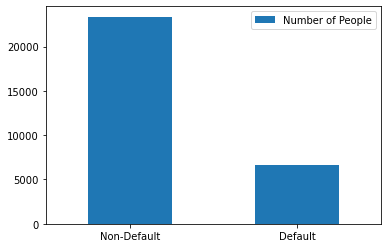

In [10]:

df = pd.DataFrame({'':['Non-Default', 'Default'], 'Number of People':[23364, 6636]})
ax = df.plot.bar(x='', y='Number of People', rot=0)


- This graph indicates a class imbalance between the two target cases that must be handled. 

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22500 entries, 12770 to 29718
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  22500 non-null  float64
 1   SEX        22500 non-null  int64  
 2   EDUCATION  22500 non-null  int64  
 3   MARRIAGE   22500 non-null  int64  
 4   AGE        22500 non-null  int64  
 5   PAY_0      22500 non-null  int64  
 6   PAY_2      22500 non-null  int64  
 7   PAY_3      22500 non-null  int64  
 8   PAY_4      22500 non-null  int64  
 9   PAY_5      22500 non-null  int64  
 10  PAY_6      22500 non-null  int64  
 11  BILL_AMT1  22500 non-null  float64
 12  BILL_AMT2  22500 non-null  float64
 13  BILL_AMT3  22500 non-null  float64
 14  BILL_AMT4  22500 non-null  float64
 15  BILL_AMT5  22500 non-null  float64
 16  BILL_AMT6  22500 non-null  float64
 17  PAY_AMT1   22500 non-null  float64
 18  PAY_AMT2   22500 non-null  float64
 19  PAY_AMT3   22500 non-null  float64
 20  PA

- Check for null values

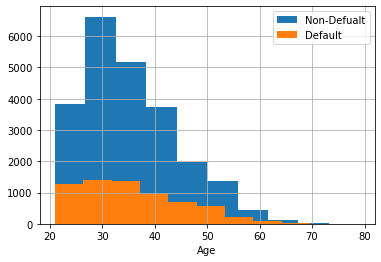

In [12]:
non_default = credit_default.loc[credit_default["default.payment.next.month"] == 0]
default = credit_default.loc[credit_default["default.payment.next.month"] == 1]

non_default_age = non_default['AGE']
default_age = default['AGE']

non_default_age_hist = non_default_age.hist()
default_age_hist = default_age.hist()

default_age_hist.set_xlabel("Age")

non_default_age_hist.legend(["Non-Defualt","Default"])

- Histogram separating the two target classes by age in a preliminary attempt to distinguish important factors.

#### Summary of Initial Observations
1. There exists a large class imbalance between defaulting and non-defaulting clients
2. There are no null values within the dataset eliminating the need for imputation.
3. The proportuions of people who default differs by age which may be a clue into the features most important to determining chances of default.

#### Chosen Metric
Due to the class imbalance present in the dataset the metric used to evaluate this model will be recall, as opposed to accuracy. 

##### Terms:

- Recall is defined as the number of true positives divided by the total number of *predicted* positives. 
- A true positive is defined as a case of client default that the model correctly predicted from the test set.

## 4. Preprocessing and transformations  

In [13]:
numeric = ["LIMIT_BAL", "AGE", "BILL_AMT1","BILL_AMT2", "BILL_AMT3", "BILL_AMT4", 
           "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", "PAY_AMT2","PAY_AMT3","PAY_AMT4",
           "PAY_AMT5","PAY_AMT6"]
ordinal = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]


transformer = make_column_transformer(
            (StandardScaler(), numeric),
            (OrdinalEncoder(), ordinal))
trans_X = transformer.fit_transform(X)
trans_X_train = transformer.fit_transform(X_train)
trans_X_test = transformer.fit_transform(X_test)

Factors within the dataset are transformed into either numeric or ordinal values to allow the model to accurately interpret the data 

## 5. Baseline model (for later comparison)

In [24]:
dummy = DummyClassifier()
dummy.fit(X,y)
dummy_pred = dummy.predict(X)
print("Recall Score: " + str(recall_score(y,dummy_pred)))

Recall Score: 0.0


In [25]:
print("Accuracy Score: "+ str(dummy.score(X,y)))

Accuracy Score: 0.7788


Sci-kit Learn's dummy classifer predicts the most common target case from the training data. The majority of individuals within this dataset did not default and therefore the dummy classifier predicts a guess of 0 (non-default) for every client. 

The dummy classifier is used as a baseline of comparison for future classifier results. In order for any model to be useful it must outperform some predetermined baseline. As previously stated, recall has been chosen as the evaluation metric for this model and therefore has been provided. It, however, is equal to zero because it has predicted that nobody will deffault.

## 6. Logistic Regression Hyperparameter Optimization 

In [45]:
lg_tune = LogisticRegression()

param_grid = {
    "C": [0.001, 0.01, 0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(
    lg_tune, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring='recall'
)
grid_search.fit(trans_X_train, y_train)
grid_search.best_params_

{'C': 10}

In [46]:
lg = LogisticRegression(max_iter = 2000, C=10)
lg_scores = cross_validate(lg, trans_X_train, y_train, return_train_score=True, scoring='recall')
pd.DataFrame(lg_scores)

,fit_time,score_time,test_score,train_score
0,0.126498,0.001563,0.259519,0.263013
1,0.133821,0.001301,0.230230,0.262078
2,0.105021,0.001267,0.266266,0.256070
3,0.123178,0.001167,0.282282,0.260325
4,0.119271,0.001244,0.266266,0.272090


## 7. Different classifiers

### Random Forest

In [34]:
rf = RandomForestClassifier()
rf_scores = cross_validate(rf,trans_X_train, y_train, return_train_score =True, scoring='recall')
pd.DataFrame(rf_scores).T

,0,1,2,3,4
fit_time,3.215489,3.181791,3.311123,3.187568,3.207783
score_time,0.065459,0.064120,0.064731,0.069143,0.067205
test_score,0.389780,0.355355,0.376376,0.379379,0.387387
train_score,0.998999,0.997497,0.998498,0.998248,0.998248


##### Mean & STD

In [35]:
print("MEAN")
print(rf_scores["test_score"].mean())
print("STD")
rf_scores["test_score"].std()

MEAN
0.37765561152334703
STD


0.012195136818357804

### Support Vector Machine

In [36]:
knn = KNeighborsClassifier()
knn_scores = cross_validate(knn,trans_X_train, y_train, return_train_score =True, scoring='recall')
pd.DataFrame(knn_scores).T

,0,1,2,3,4
fit_time,0.002554,0.001608,0.001576,0.001655,0.001591
score_time,1.385283,1.346404,1.197883,1.319418,1.322140
test_score,0.360721,0.345345,0.366366,0.361361,0.362362
train_score,0.471221,0.465832,0.473842,0.471840,0.468836


##### Mean & STD

In [37]:
print("MEAN")
print(knn_scores["test_score"].mean())
print("STD")
knn_scores["test_score"].std()

MEAN
0.3592313756642414
STD


0.007215125049992348

### CatBoost

In [38]:
cb = CatBoostClassifier(verbose = False)
cb_scores = cross_validate(cb,trans_X_train, y_train, return_train_score =True, scoring='recall')
pd.DataFrame(cb_scores).T

,0,1,2,3,4
fit_time,4.898841,4.514651,4.698102,4.878217,4.817510
score_time,0.024668,0.022883,0.022314,0.022660,0.022399
test_score,0.388778,0.355355,0.381381,0.384384,0.387387
train_score,0.484234,0.475344,0.479599,0.481602,0.472591


##### Mean & STD

In [40]:
print("MEAN")
print(cb_scores["test_score"].mean())
print("STD")
cb_scores["test_score"].std()

MEAN
0.3794572127237458
STD


0.012317754881467996

### XGB

In [39]:
xgb = XGBClassifier()
xgb_scores = cross_validate(xgb,trans_X_train, y_train, return_train_score =True, scoring='recall')
pd.DataFrame(xgb_scores).T

/Users/LoganDeboo/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/LoganDeboo/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/LoganDeboo/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/LoganDeboo/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/LoganDeboo/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:49:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,0,1,2,3,4
fit_time,1.827792,1.540031,1.772761,1.812448,1.609709
score_time,0.009374,0.005897,0.010345,0.006492,0.006383
test_score,0.390782,0.351351,0.367367,0.370370,0.366366
train_score,0.601852,0.590488,0.594994,0.604005,0.585982


##### Mean & STD

In [41]:
print("MEAN")
print(xgb_scores["test_score"].mean())
print("STD")
xgb_scores["test_score"].std()

MEAN
0.3692474037163416
STD


0.012626041966771724

### LightGBM

In [42]:
gbm = LGBMClassifier()
gbm_scores = cross_validate(gbm,trans_X_train, y_train, return_train_score =True, scoring='recall')
pd.DataFrame(xgb_scores).T

,0,1,2,3,4
fit_time,1.827792,1.540031,1.772761,1.812448,1.609709
score_time,0.009374,0.005897,0.010345,0.006492,0.006383
test_score,0.390782,0.351351,0.367367,0.370370,0.366366
train_score,0.601852,0.590488,0.594994,0.604005,0.585982


##### Mean & STD

In [43]:
print("MEAN")
print(gbm_scores["test_score"].mean())
print("STD")
gbm_scores["test_score"].std()

MEAN
0.37385060411112514
STD


0.009670790380677924

#### Summary

In [44]:
data = {'Algorithm':['Random Forest', 'K Nearest Neighbors', 'CatBoost', 'XGB', 'LightGBM', 'Logistic Regression'],
        'Mean':[rf_scores["test_score"].mean(),knn_scores["test_score"].mean(), cb_scores["test_score"].mean(),
               xgb_scores["test_score"].mean(),gbm_scores["test_score"].mean(),lg_scores["test_score"].mean()],
       'STD':[rf_scores["test_score"].std(),knn_scores["test_score"].std(), cb_scores["test_score"].std(),
               xgb_scores["test_score"].std(),gbm_scores["test_score"].std(), 0.0043248]}

pd.DataFrame(data)

,Algorithm,Mean,STD
0,Random Forest,0.377656,0.012195
1,K Nearest Neighbors,0.359231,0.007215
2,CatBoost,0.379457,0.012318
3,XGB,0.369247,0.012626
4,LightGBM,0.373851,0.009671
5,Logistic Regression,0.260913,0.004325
